In [15]:
import numpy as np
import pandas as pd
from sklearn .model_selection import train_test_split
import random
from collections import Counter


In [16]:
def load_data():
    df = pd.read_csv("iris.data", header=None)
    df.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Class']
    return df

In [17]:
def divide_data(df, seed):
    # converts the dataframe into list
    data = df.values.tolist()
    # prepares 3 list for each type
    data_setosa = []
    data_versicolor = []
    data_virginica = []

    # assigns each to its list accordingly
    for datum in data:
        if datum[4] == "Iris-setosa":
            data_setosa.append(datum)
        elif datum[4] == "Iris-versicolor":
            data_versicolor.append(datum)
        elif datum[4] == "Iris-virginica":
            data_virginica.append(datum)
            
    # divides the data into input and label
    X_setosa = [row[:4] for row in data_setosa] # gets first 4 columns as input 
    Y_setosa = [row[4] for row in data_setosa] # class label as last column

    # randomly divides each data by 50/50 train and test while maintaining class balance
    x_setosa_train, x_setosa_test, y_setosa_train, y_setosa_test = train_test_split(X_setosa, Y_setosa, test_size = 0.5, random_state=seed, shuffle=True)


    X_versicolor = [row[:4] for row in data_versicolor] # gets first 4 columns as input 
    Y_versicolor = [row[4] for row in data_versicolor] # class label as last column

    x_versicolor_train, x_versicolor_test, y_versicolor_train, y_versicolor_test = train_test_split(X_versicolor, Y_versicolor, test_size = 0.5, random_state=seed, shuffle=True)


    X_virginica = [row[:4] for row in data_virginica] # gets first 4 columns as input 
    Y_virginica = [row[4] for row in data_virginica] # class label as last column

    x_virginica_train, x_virginica_test, y_virginica_train, y_virginica_test = train_test_split(X_virginica, Y_virginica, test_size = 0.5, random_state=seed, shuffle=True)

    random.seed(seed)
    # merges back the dataset into general x train, y train, x test and y test
    X_train = x_setosa_train + x_versicolor_train + x_virginica_train
    Y_train = y_setosa_train + y_versicolor_train + y_virginica_train

    #shuffles while keeping the order
    combined_train = list(zip(X_train, Y_train))
    random.shuffle(combined_train)
    X_train, Y_train = zip(*combined_train)


    X_test = x_setosa_test + x_versicolor_test + x_virginica_test
    Y_test = y_setosa_test + y_versicolor_test + y_virginica_test
    combined_test = list(zip(X_test, Y_test))
    random.shuffle(combined_test)
    X_test, Y_test = zip(*combined_test)

    return X_train, Y_train, X_test, Y_test

In [18]:
def process_data(X_train, Y_train, X_test, Y_test, interest):
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    #dividing training into one species vs others
    x_train_1 = []
    x_train_0 = []
    for i, x_train in enumerate(X_train):
        if Y_train[i] == interest:
            x_train_1.append(x_train)
        else:
            x_train_0.append(x_train)

    x_train_1 = np.array(x_train_1)
    x_train_0 = np.array(x_train_0)

    # converting Y ground truth labels into binary one species: 1 other: 0
    Y_train_bin = []
    Y_test_bin = []
    for y_train in Y_train:
        if y_train == interest:
            Y_train_bin.append(1)
        else:
            Y_train_bin.append(0)

    for y_test in Y_test:
        if y_test == interest:
            Y_test_bin.append(1)
        else:
            Y_test_bin.append(0)

    Y_train = np.array(Y_train_bin)
    Y_test = np.array(Y_test_bin)

    # Calculates mean of each class
    mu_1 = np.mean(x_train_1, axis=0)
    mu_0 = np.mean(x_train_0, axis=0)

    # print(mu_1)
    # print(mu_0)

    # print(len(x_train_0))
    # print(len(x_train_1))

    # print(Y_train)
    # print(Y_test)
    # print(len(Y_train))
    # print(len(Y_test))
    return X_train, Y_train, X_test, Y_test, x_train_1, x_train_0, mu_1, mu_0

In [19]:
def fischer_train(x_train_1, x_train_0, mu_1, mu_0):
    # within class scatter matrix for class 1 and 0
    S1 = (x_train_1 - mu_1).T @ (x_train_1 - mu_1)
    S0 = (x_train_0 - mu_0).T @ (x_train_0 - mu_0)
    # total within class scatter matrix
    SW = S0 + S1
    #calculates the projection direction vector w = SW(-1)(mu1−mu0)
    w = np.linalg.inv(SW) @ (mu_1 - mu_0)
    #midpoint threshold between means for deciding whether point belongs to class 1 or 0
    threshold = 0.5 * (w @ mu_1 + w @ mu_0)
    
    return w, threshold
    

In [20]:
def fischer_predict(X_test, w, threshold):
    # project the new data and if it is higher than the threshold class 1 if not 0
    predictions = []
    for x_test in X_test:
        projection = x_test @ w
        if(projection >= threshold):
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [21]:
def evaluate(predictions, Y_test):
    # evaluation part
    if len(Y_test) != len(predictions):
        print("Prediction size did not match with ground truth labels!")
        
    sample_size = len(Y_test)
    correct_prediction = 0
    for prediction, y_test in zip(predictions, Y_test):
        if prediction == y_test:
            correct_prediction += 1

    return correct_prediction / sample_size

In [22]:
def execute_experiment(interest, random_seed):
    df = load_data()
    #print(df)
    X_train, Y_train, X_test, Y_test = divide_data(df, random_seed)
    X_train, Y_train, X_test, Y_test, x_train_1, x_train_0, mu_1, mu_0 = process_data(X_train, Y_train, X_test, Y_test, interest)
    w, threshold = fischer_train(x_train_1, x_train_0, mu_1, mu_0)
    predictions = fischer_predict(X_test, w, threshold)
    return evaluate(predictions, Y_test)

In [23]:
# one time experiment for testing

interest = "Iris-setosa"
print(execute_experiment(interest, 42))
interest = "Iris-versicolor"
print(execute_experiment(interest, 42))
interest = "Iris-virginica"
print(execute_experiment(interest, 42))



1.0
0.6666666666666666
0.9333333333333333


In [24]:
# conducting the experiment 20 times
accuracy_setosa = []
accuracy_versicolor = []
accuracy_virginica = []
for i in range(20):
    random_seed = random.randint(0, 4294967295)
    interest = "Iris-setosa"
    accuracy_setosa.append(execute_experiment(interest, random_seed))
    
    interest = "Iris-versicolor"
    accuracy_versicolor.append(execute_experiment(interest, random_seed))
    
    interest = "Iris-virginica"
    accuracy_virginica.append(execute_experiment(interest, random_seed))

print(f"Mean accuracy of 20 experiments setosa: {np.mean(accuracy_setosa)}")
print(f"Mean accuracy of 20 experiments versicolor: {np.mean(accuracy_versicolor)}")
print(f"Mean accuracy of 20 experiments virginica: {np.mean(accuracy_virginica)}")

Mean accuracy of 20 experiments setosa: 1.0
Mean accuracy of 20 experiments versicolor: 0.7166666666666666
Mean accuracy of 20 experiments virginica: 0.8793333333333333


In [26]:
sum = 0
for accuracy in accuracy_setosa:
    # sum = sum of (x(i) - x_mean)^2
    sum += (accuracy - np.mean(accuracy_setosa)) ** 2
# sum / n-1
sample_variance_setosa = sum / 20
print(f"20 Sample variance setosa: {sample_variance_setosa}")

sum = 0
for accuracy in accuracy_versicolor:
    # sum = sum of (x(i) - x_mean)^2
    sum += (accuracy - np.mean(accuracy_versicolor)) ** 2
# sum / n-1
sample_variance_versicolor = sum / 20
print(f"20 Sample variance versicolor: {sample_variance_versicolor}")

sum = 0
for accuracy in accuracy_virginica:
    # sum = sum of (x(i) - x_mean)^2
    sum += (accuracy - np.mean(accuracy_virginica)) ** 2
# sum / n-1
sample_variance_virginica = sum / 20
print(f"20 Sample variance virginica: {sample_variance_virginica}")



20 Sample variance setosa: 0.0
20 Sample variance versicolor: 0.0022199999999999998
20 Sample variance virginica: 0.0007728888888888884


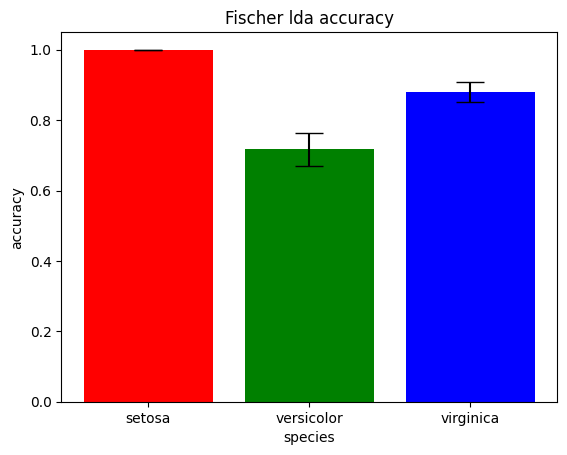

<Figure size 700x400 with 0 Axes>

Mean accuracy: [1.0, 0.7166666666666666, 0.8793333333333333]
Standard deviation: [0.0, 0.047116875957558986, 0.02780087928265738]
Variance: [0.0, 0.0022199999999999998, 0.0007728888888888884]


In [28]:
import matplotlib.pyplot as plt

mean_accuracy = []
mean_accuracy.append(np.mean(accuracy_setosa))
mean_accuracy.append(np.mean(accuracy_versicolor))
mean_accuracy.append(np.mean(accuracy_virginica))

std_dev = []
std_dev.append(np.std(accuracy_setosa))
std_dev.append(np.std(accuracy_versicolor))
std_dev.append(np.std(accuracy_virginica))

variance = []
variance.append(sample_variance_setosa)
variance.append(sample_variance_versicolor)
variance.append(sample_variance_virginica)

# mean plot
plt.bar(['setosa', 'versicolor', 'virginica'], mean_accuracy, yerr=std_dev, capsize=10, color=['red', 'green', 'blue'])
plt.title('Fischer lda accuracy')
plt.xlabel('species')
plt.ylabel('accuracy')
plt.figure(figsize=(7, 4))
plt.show()

print(f"Mean accuracy: {mean_accuracy}")
print(f"Standard deviation: {std_dev}")
print(f"Variance: {variance}")